In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import models
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_score, recall_score
import warnings

warnings.filterwarnings("ignore")

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


True
Tesla P100-PCIE-16GB


In [2]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import OneCycleLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from PIL import Image
import shutil
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from PIL import Image

In [3]:
def get_file_paths(directory):
    return [os.path.join(dirpath, f) for dirpath, _, filenames in os.walk(directory) for f in filenames if f.endswith('.jpg')]

# benign_dir = "/kaggle/input/iaaa-mri-train-data-partition/iaaa-mri-train-data partition/data/benign"
# malignant_dir = "/kaggle/input/iaaa-mri-train-data-partition/iaaa-mri-train-data partition/data/malignant"
benign_dir = "/kaggle/input/body-part-examined/benign/BRAIN"
malignant_dir = "/kaggle/input/body-part-examined/malignant/BRAIN"

benign_files = get_file_paths(benign_dir)
malignant_files = get_file_paths(malignant_dir)

benign_labels = [0] * len(benign_files)
malignant_labels = [1] * len(malignant_files)

file_paths = benign_files + malignant_files
labels = benign_labels + malignant_labels
df = pd.DataFrame({"file_path": file_paths, "label": labels})

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Number of benign files: {len(benign_files)}")
print(f"Number of malignant files: {len(malignant_files)}")

if len(benign_files) == 0 or len(malignant_files) == 0:
    raise ValueError("No image files found in one or both directories. Please check the file paths.")

oversampler = RandomOverSampler(random_state=42)
file_paths_resampled, labels_resampled = oversampler.fit_resample(
    train_df['file_path'].values.reshape(-1, 1), train_df['label']
)
train_df_resampled = pd.DataFrame({"file_path": file_paths_resampled.flatten(), "label": labels_resampled})

Number of benign files: 1152
Number of malignant files: 388


In [4]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

class BrainDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        label = self.dataframe.iloc[idx]['label']

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, torch.tensor(label, dtype=torch.float32)

def create_transforms():
    train_transform = A.Compose([
        A.Resize(224, 224),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    val_transform = A.Compose([
        A.Resize(224, 224),
        A.Flip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    return train_transform, val_transform

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True)
        self.psi = nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        if g1.shape != x1.shape:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=False)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * self.sigmoid(psi)

class BrainTumorModel(nn.Module):
    def __init__(self):
        super(BrainTumorModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.attention1 = AttentionGate(2048, 1024, 512)
        self.attention2 = AttentionGate(2048, 512, 256)
        self.attention3 = AttentionGate(2048, 256, 128)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x1 = self.resnet.layer1(x)
        x2 = self.resnet.layer2(x1)
        x3 = self.resnet.layer3(x2)
        x4 = self.resnet.layer4(x3)

        x3 = self.attention1(x4, x3)
        x2 = self.attention2(x4, x2)
        x1 = self.attention3(x4, x1)

        x = self.global_pool(x4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def test_model(model, test_loader, device):
    model.eval()
    predictions = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).cpu().numpy()
            predictions.extend(preds)
            labels.extend(targets.numpy())
    
    return predictions, labels

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, scaler):
    best_val_recall = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs).squeeze(1)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            train_preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (train_preds == labels).sum().item()
            train_total += labels.size(0)
        
        train_accuracy = train_correct / train_total
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze(1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        
        val_accuracy = val_correct / val_total
        val_loss /= len(val_loader)
        val_precision = precision_score(val_true, val_preds)
        val_recall = recall_score(val_true, val_preds)
        
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")
        
        if val_recall > best_val_recall:
            best_val_recall = val_recall
            torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Best validation recall: {best_val_recall:.4f}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform, val_transform = create_transforms()

train_dataset = BrainDataset(train_df_resampled, transform=train_transform)
val_dataset = BrainDataset(val_df, transform=val_transform)
test_dataset = BrainDataset(test_df, transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

model = BrainTumorModel().to(device)
criterion = FocalLoss(alpha=0.25, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
num_epochs = 60
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, epochs=num_epochs, steps_per_epoch=steps_per_epoch)
scaler = GradScaler()

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, scaler)

model.load_state_dict(torch.load('best_model.pth'))
predictions, labels = test_model(model, test_loader, device)

new_list = [0 if value <= 0.50 else 1 for value in predictions]

cf = confusion_matrix(labels, new_list)
tn, fp, fn, tp = cf.ravel()

print(f"\nModel performance:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n")

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1_score:.4f}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]
Epoch 1/60: 100%|██████████| 51/51 [00:10<00:00,  4.76it/s]


Epoch 1/60
Train Loss: 0.0410, Train Accuracy: 0.6042
Val Loss: 0.0307, Val Accuracy: 0.7403
Val Precision: 0.4808, Val Recall: 0.4310


Epoch 2/60: 100%|██████████| 51/51 [00:08<00:00,  5.70it/s]


Epoch 2/60
Train Loss: 0.0374, Train Accuracy: 0.6799
Val Loss: 0.0284, Val Accuracy: 0.8182
Val Precision: 0.6081, Val Recall: 0.7759


Epoch 3/60: 100%|██████████| 51/51 [00:09<00:00,  5.66it/s]


Epoch 3/60
Train Loss: 0.0309, Train Accuracy: 0.7512
Val Loss: 0.0214, Val Accuracy: 0.8571
Val Precision: 0.6866, Val Recall: 0.7931


Epoch 4/60: 100%|██████████| 51/51 [00:08<00:00,  5.70it/s]


Epoch 4/60
Train Loss: 0.0274, Train Accuracy: 0.7978
Val Loss: 0.0176, Val Accuracy: 0.8874
Val Precision: 0.8077, Val Recall: 0.7241


Epoch 5/60: 100%|██████████| 51/51 [00:08<00:00,  5.71it/s]


Epoch 5/60
Train Loss: 0.0255, Train Accuracy: 0.8102
Val Loss: 0.0185, Val Accuracy: 0.8788
Val Precision: 0.7027, Val Recall: 0.8966


Epoch 6/60: 100%|██████████| 51/51 [00:08<00:00,  5.68it/s]


Epoch 6/60
Train Loss: 0.0235, Train Accuracy: 0.8443
Val Loss: 0.0200, Val Accuracy: 0.8615
Val Precision: 0.6625, Val Recall: 0.9138


Epoch 7/60: 100%|██████████| 51/51 [00:09<00:00,  5.66it/s]


Epoch 7/60
Train Loss: 0.0230, Train Accuracy: 0.8455
Val Loss: 0.0148, Val Accuracy: 0.9307
Val Precision: 0.8750, Val Recall: 0.8448


Epoch 8/60: 100%|██████████| 51/51 [00:08<00:00,  5.70it/s]


Epoch 8/60
Train Loss: 0.0197, Train Accuracy: 0.8679
Val Loss: 0.0117, Val Accuracy: 0.9177
Val Precision: 0.8824, Val Recall: 0.7759


Epoch 9/60: 100%|██████████| 51/51 [00:08<00:00,  5.68it/s]


Epoch 9/60
Train Loss: 0.0200, Train Accuracy: 0.8548
Val Loss: 0.0118, Val Accuracy: 0.9307
Val Precision: 0.8387, Val Recall: 0.8966


Epoch 10/60: 100%|██████████| 51/51 [00:09<00:00,  5.56it/s]


Epoch 10/60
Train Loss: 0.0184, Train Accuracy: 0.8803
Val Loss: 0.0089, Val Accuracy: 0.9307
Val Precision: 0.8750, Val Recall: 0.8448


Epoch 11/60: 100%|██████████| 51/51 [00:08<00:00,  5.67it/s]


Epoch 11/60
Train Loss: 0.0160, Train Accuracy: 0.9001
Val Loss: 0.0100, Val Accuracy: 0.9394
Val Precision: 0.9231, Val Recall: 0.8276


Epoch 12/60: 100%|██████████| 51/51 [00:08<00:00,  5.69it/s]


Epoch 12/60
Train Loss: 0.0161, Train Accuracy: 0.9014
Val Loss: 0.0103, Val Accuracy: 0.9134
Val Precision: 0.9318, Val Recall: 0.7069


Epoch 13/60: 100%|██████████| 51/51 [00:08<00:00,  5.68it/s]


Epoch 13/60
Train Loss: 0.0158, Train Accuracy: 0.8952
Val Loss: 0.0131, Val Accuracy: 0.9221
Val Precision: 0.9000, Val Recall: 0.7759


Epoch 14/60: 100%|██████████| 51/51 [00:08<00:00,  5.68it/s]


Epoch 14/60
Train Loss: 0.0142, Train Accuracy: 0.9057
Val Loss: 0.0120, Val Accuracy: 0.9221
Val Precision: 0.7941, Val Recall: 0.9310


Epoch 15/60: 100%|██████████| 51/51 [00:08<00:00,  5.68it/s]


Epoch 15/60
Train Loss: 0.0134, Train Accuracy: 0.9119
Val Loss: 0.0083, Val Accuracy: 0.9610
Val Precision: 0.9804, Val Recall: 0.8621


Epoch 16/60: 100%|██████████| 51/51 [00:08<00:00,  5.69it/s]


Epoch 16/60
Train Loss: 0.0127, Train Accuracy: 0.9268
Val Loss: 0.0126, Val Accuracy: 0.9481
Val Precision: 0.8710, Val Recall: 0.9310


Epoch 17/60: 100%|██████████| 51/51 [00:08<00:00,  5.68it/s]


Epoch 17/60
Train Loss: 0.0119, Train Accuracy: 0.9218
Val Loss: 0.0077, Val Accuracy: 0.9567
Val Precision: 0.8871, Val Recall: 0.9483


Epoch 18/60: 100%|██████████| 51/51 [00:08<00:00,  5.70it/s]


Epoch 18/60
Train Loss: 0.0123, Train Accuracy: 0.9249
Val Loss: 0.0056, Val Accuracy: 0.9697
Val Precision: 0.9636, Val Recall: 0.9138


Epoch 19/60: 100%|██████████| 51/51 [00:09<00:00,  5.66it/s]


Epoch 19/60
Train Loss: 0.0122, Train Accuracy: 0.9299
Val Loss: 0.0141, Val Accuracy: 0.9437
Val Precision: 1.0000, Val Recall: 0.7759


Epoch 20/60: 100%|██████████| 51/51 [00:08<00:00,  5.69it/s]


Epoch 20/60
Train Loss: 0.0113, Train Accuracy: 0.9311
Val Loss: 0.0113, Val Accuracy: 0.9394
Val Precision: 0.8548, Val Recall: 0.9138


Epoch 21/60: 100%|██████████| 51/51 [00:08<00:00,  5.70it/s]


Epoch 21/60
Train Loss: 0.0131, Train Accuracy: 0.9163
Val Loss: 0.0113, Val Accuracy: 0.9437
Val Precision: 0.9412, Val Recall: 0.8276


Epoch 22/60: 100%|██████████| 51/51 [00:09<00:00,  5.65it/s]


Epoch 22/60
Train Loss: 0.0110, Train Accuracy: 0.9349
Val Loss: 0.0081, Val Accuracy: 0.9567
Val Precision: 0.9286, Val Recall: 0.8966


Epoch 23/60: 100%|██████████| 51/51 [00:09<00:00,  5.47it/s]


Epoch 23/60
Train Loss: 0.0097, Train Accuracy: 0.9442
Val Loss: 0.0094, Val Accuracy: 0.9437
Val Precision: 0.9412, Val Recall: 0.8276


Epoch 24/60: 100%|██████████| 51/51 [00:09<00:00,  5.62it/s]


Epoch 24/60
Train Loss: 0.0094, Train Accuracy: 0.9423
Val Loss: 0.0065, Val Accuracy: 0.9567
Val Precision: 0.9800, Val Recall: 0.8448


Epoch 25/60: 100%|██████████| 51/51 [00:09<00:00,  5.60it/s]


Epoch 25/60
Train Loss: 0.0109, Train Accuracy: 0.9324
Val Loss: 0.0074, Val Accuracy: 0.9567
Val Precision: 0.9800, Val Recall: 0.8448


Epoch 26/60: 100%|██████████| 51/51 [00:09<00:00,  5.59it/s]


Epoch 26/60
Train Loss: 0.0087, Train Accuracy: 0.9522
Val Loss: 0.0110, Val Accuracy: 0.9524
Val Precision: 0.9796, Val Recall: 0.8276


Epoch 27/60: 100%|██████████| 51/51 [00:09<00:00,  5.65it/s]


Epoch 27/60
Train Loss: 0.0080, Train Accuracy: 0.9566
Val Loss: 0.0070, Val Accuracy: 0.9567
Val Precision: 0.8871, Val Recall: 0.9483


Epoch 28/60: 100%|██████████| 51/51 [00:09<00:00,  5.63it/s]


Epoch 28/60
Train Loss: 0.0083, Train Accuracy: 0.9491
Val Loss: 0.0083, Val Accuracy: 0.9610
Val Precision: 0.9623, Val Recall: 0.8793


Epoch 29/60: 100%|██████████| 51/51 [00:09<00:00,  5.57it/s]


Epoch 29/60
Train Loss: 0.0079, Train Accuracy: 0.9498
Val Loss: 0.0083, Val Accuracy: 0.9481
Val Precision: 0.8833, Val Recall: 0.9138


Epoch 30/60: 100%|██████████| 51/51 [00:09<00:00,  5.60it/s]


Epoch 30/60
Train Loss: 0.0098, Train Accuracy: 0.9460
Val Loss: 0.0063, Val Accuracy: 0.9654
Val Precision: 0.9464, Val Recall: 0.9138


Epoch 31/60: 100%|██████████| 51/51 [00:09<00:00,  5.66it/s]


Epoch 31/60
Train Loss: 0.0082, Train Accuracy: 0.9510
Val Loss: 0.0092, Val Accuracy: 0.9524
Val Precision: 0.9796, Val Recall: 0.8276


Epoch 32/60: 100%|██████████| 51/51 [00:09<00:00,  5.63it/s]


Epoch 32/60
Train Loss: 0.0075, Train Accuracy: 0.9553
Val Loss: 0.0096, Val Accuracy: 0.9481
Val Precision: 0.8710, Val Recall: 0.9310


Epoch 33/60: 100%|██████████| 51/51 [00:09<00:00,  5.64it/s]


Epoch 33/60
Train Loss: 0.0091, Train Accuracy: 0.9547
Val Loss: 0.0106, Val Accuracy: 0.9394
Val Precision: 0.9231, Val Recall: 0.8276


Epoch 34/60: 100%|██████████| 51/51 [00:09<00:00,  5.60it/s]


Epoch 34/60
Train Loss: 0.0075, Train Accuracy: 0.9572
Val Loss: 0.0064, Val Accuracy: 0.9481
Val Precision: 0.8710, Val Recall: 0.9310


Epoch 35/60: 100%|██████████| 51/51 [00:09<00:00,  5.62it/s]


Epoch 35/60
Train Loss: 0.0072, Train Accuracy: 0.9609
Val Loss: 0.0100, Val Accuracy: 0.9610
Val Precision: 0.9804, Val Recall: 0.8621


Epoch 36/60: 100%|██████████| 51/51 [00:09<00:00,  5.56it/s]


Epoch 36/60
Train Loss: 0.0067, Train Accuracy: 0.9653
Val Loss: 0.0062, Val Accuracy: 0.9610
Val Precision: 0.9804, Val Recall: 0.8621


Epoch 37/60: 100%|██████████| 51/51 [00:09<00:00,  5.61it/s]


Epoch 37/60
Train Loss: 0.0077, Train Accuracy: 0.9603
Val Loss: 0.0105, Val Accuracy: 0.9394
Val Precision: 1.0000, Val Recall: 0.7586


Epoch 38/60: 100%|██████████| 51/51 [00:08<00:00,  5.67it/s]


Epoch 38/60
Train Loss: 0.0078, Train Accuracy: 0.9578
Val Loss: 0.0092, Val Accuracy: 0.9654
Val Precision: 1.0000, Val Recall: 0.8621


Epoch 39/60: 100%|██████████| 51/51 [00:09<00:00,  5.63it/s]


Epoch 39/60
Train Loss: 0.0077, Train Accuracy: 0.9553
Val Loss: 0.0060, Val Accuracy: 0.9524
Val Precision: 0.9796, Val Recall: 0.8276


Epoch 40/60: 100%|██████████| 51/51 [00:09<00:00,  5.66it/s]


Epoch 40/60
Train Loss: 0.0071, Train Accuracy: 0.9615
Val Loss: 0.0141, Val Accuracy: 0.9351
Val Precision: 1.0000, Val Recall: 0.7414


Epoch 41/60: 100%|██████████| 51/51 [00:09<00:00,  5.67it/s]


Epoch 41/60
Train Loss: 0.0084, Train Accuracy: 0.9516
Val Loss: 0.0147, Val Accuracy: 0.9437
Val Precision: 0.8814, Val Recall: 0.8966


Epoch 42/60: 100%|██████████| 51/51 [00:09<00:00,  5.66it/s]


Epoch 42/60
Train Loss: 0.0078, Train Accuracy: 0.9547
Val Loss: 0.0068, Val Accuracy: 0.9481
Val Precision: 0.9259, Val Recall: 0.8621


Epoch 43/60: 100%|██████████| 51/51 [00:09<00:00,  5.66it/s]


Epoch 43/60
Train Loss: 0.0072, Train Accuracy: 0.9529
Val Loss: 0.0116, Val Accuracy: 0.9524
Val Precision: 0.9796, Val Recall: 0.8276


Epoch 44/60: 100%|██████████| 51/51 [00:09<00:00,  5.65it/s]


Epoch 44/60
Train Loss: 0.0060, Train Accuracy: 0.9708
Val Loss: 0.0136, Val Accuracy: 0.9351
Val Precision: 0.8909, Val Recall: 0.8448


Epoch 45/60: 100%|██████████| 51/51 [00:08<00:00,  5.68it/s]


Epoch 45/60
Train Loss: 0.0059, Train Accuracy: 0.9671
Val Loss: 0.0083, Val Accuracy: 0.9610
Val Precision: 1.0000, Val Recall: 0.8448


Epoch 46/60: 100%|██████████| 51/51 [00:08<00:00,  5.68it/s]


Epoch 46/60
Train Loss: 0.0046, Train Accuracy: 0.9727
Val Loss: 0.0106, Val Accuracy: 0.9610
Val Precision: 0.9804, Val Recall: 0.8621


Epoch 47/60: 100%|██████████| 51/51 [00:08<00:00,  5.68it/s]


Epoch 47/60
Train Loss: 0.0055, Train Accuracy: 0.9659
Val Loss: 0.0215, Val Accuracy: 0.9177
Val Precision: 1.0000, Val Recall: 0.6724


Epoch 48/60: 100%|██████████| 51/51 [00:08<00:00,  5.68it/s]


Epoch 48/60
Train Loss: 0.0056, Train Accuracy: 0.9659
Val Loss: 0.0058, Val Accuracy: 0.9654
Val Precision: 0.9808, Val Recall: 0.8793


Epoch 49/60: 100%|██████████| 51/51 [00:09<00:00,  5.56it/s]


Epoch 49/60
Train Loss: 0.0072, Train Accuracy: 0.9622
Val Loss: 0.0077, Val Accuracy: 0.9610
Val Precision: 0.9455, Val Recall: 0.8966


Epoch 50/60: 100%|██████████| 51/51 [00:08<00:00,  5.71it/s]


Epoch 50/60
Train Loss: 0.0057, Train Accuracy: 0.9696
Val Loss: 0.0089, Val Accuracy: 0.9740
Val Precision: 0.9815, Val Recall: 0.9138


Epoch 51/60: 100%|██████████| 51/51 [00:08<00:00,  5.72it/s]


Epoch 51/60
Train Loss: 0.0046, Train Accuracy: 0.9746
Val Loss: 0.0104, Val Accuracy: 0.9524
Val Precision: 0.9796, Val Recall: 0.8276


Epoch 52/60: 100%|██████████| 51/51 [00:08<00:00,  5.71it/s]


Epoch 52/60
Train Loss: 0.0075, Train Accuracy: 0.9671
Val Loss: 0.0078, Val Accuracy: 0.9610
Val Precision: 0.9016, Val Recall: 0.9483


Epoch 53/60: 100%|██████████| 51/51 [00:08<00:00,  5.71it/s]


Epoch 53/60
Train Loss: 0.0071, Train Accuracy: 0.9591
Val Loss: 0.0056, Val Accuracy: 0.9654
Val Precision: 1.0000, Val Recall: 0.8621


Epoch 54/60: 100%|██████████| 51/51 [00:08<00:00,  5.68it/s]


Epoch 54/60
Train Loss: 0.0049, Train Accuracy: 0.9721
Val Loss: 0.0083, Val Accuracy: 0.9654
Val Precision: 0.9808, Val Recall: 0.8793


Epoch 55/60: 100%|██████████| 51/51 [00:09<00:00,  5.66it/s]


Epoch 55/60
Train Loss: 0.0064, Train Accuracy: 0.9665
Val Loss: 0.0079, Val Accuracy: 0.9481
Val Precision: 0.8594, Val Recall: 0.9483


Epoch 56/60: 100%|██████████| 51/51 [00:08<00:00,  5.71it/s]


Epoch 56/60
Train Loss: 0.0065, Train Accuracy: 0.9659
Val Loss: 0.0079, Val Accuracy: 0.9567
Val Precision: 0.9444, Val Recall: 0.8793


Epoch 57/60: 100%|██████████| 51/51 [00:08<00:00,  5.69it/s]


Epoch 57/60
Train Loss: 0.0087, Train Accuracy: 0.9671
Val Loss: 0.0054, Val Accuracy: 0.9654
Val Precision: 0.9808, Val Recall: 0.8793


Epoch 58/60: 100%|██████████| 51/51 [00:08<00:00,  5.67it/s]


Epoch 58/60
Train Loss: 0.0044, Train Accuracy: 0.9795
Val Loss: 0.0077, Val Accuracy: 0.9697
Val Precision: 0.9474, Val Recall: 0.9310


Epoch 59/60: 100%|██████████| 51/51 [00:08<00:00,  5.70it/s]


Epoch 59/60
Train Loss: 0.0041, Train Accuracy: 0.9845
Val Loss: 0.0036, Val Accuracy: 0.9610
Val Precision: 0.9455, Val Recall: 0.8966


Epoch 60/60: 100%|██████████| 51/51 [00:08<00:00,  5.69it/s]


Epoch 60/60
Train Loss: 0.0078, Train Accuracy: 0.9727
Val Loss: 0.0174, Val Accuracy: 0.9567
Val Precision: 0.9444, Val Recall: 0.8793
Best validation recall: 0.9483


100%|██████████| 8/8 [00:00<00:00,  8.93it/s]



Model performance:
TN: 169, FP: 4, FN: 6, TP: 52

Test Accuracy: 0.9567
Test Precision: 0.9286
Test Recall: 0.8966
Test F1-Score: 0.9123


In [5]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.sigmoid(outputs)
            all_preds.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels)
    
    auc = roc_auc_score(all_labels, all_preds)
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    
    precision, recall, thresholds = precision_recall_curve(all_labels, all_preds)
    
    ap = average_precision_score(all_labels, all_preds)
    
    binary_preds = (all_preds >= 0.5).astype(int)
    avg_recall = recall_score(all_labels, binary_preds)
    
    avg_f1 = f1_score(all_labels, binary_preds)

    return auc, fpr, tpr, precision, recall, ap, avg_recall, avg_f1, all_preds, all_labels

auc, fpr, tpr, precision, recall, ap, avg_recall, avg_f1, all_preds, all_labels = evaluate_model(model, test_loader, device)

print(f"AUC: {auc:.4f}")
print(f"Average Precision: {ap:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score (Precision-Recall): {avg_f1:.4f}")

Evaluating: 100%|██████████| 8/8 [00:00<00:00,  9.19it/s]


AUC: 0.9803
Average Precision: 0.9596
Average Recall: 0.8793
Average F1 Score (Precision-Recall): 0.8793


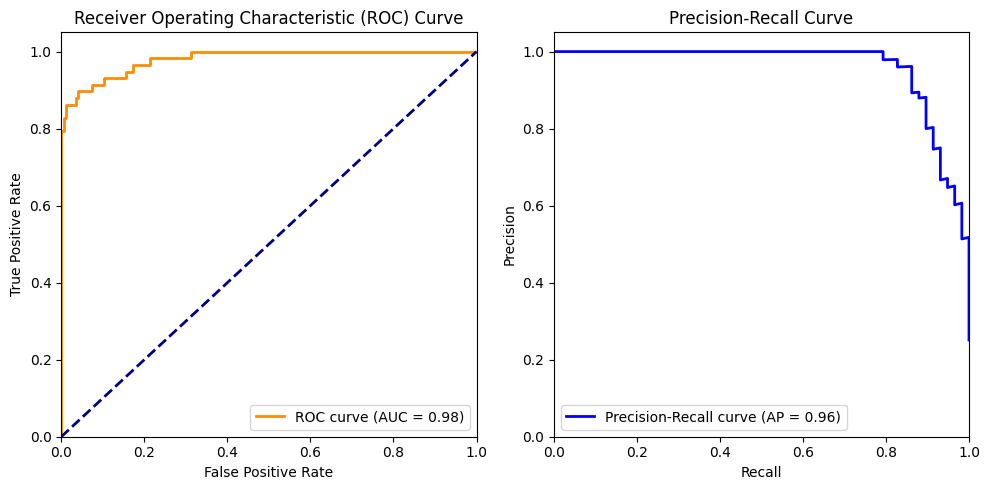

Threshold: 0.3
Recall: 0.9310
Precision: 0.7105

Threshold: 0.5
Recall: 0.8793
Precision: 0.8793

Threshold: 0.7
Recall: 0.8276
Precision: 0.9796



In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {ap:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

thresholds = [0.3, 0.5, 0.7]
for threshold in thresholds:
    y_pred = (all_preds >= threshold).astype(int)
    true_positives = np.sum((y_pred == 1) & (all_labels == 1))
    false_positives = np.sum((y_pred == 1) & (all_labels == 0))
    false_negatives = np.sum((y_pred == 0) & (all_labels == 1))
    
    recall = true_positives / (true_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives)
    
    print(f"Threshold: {threshold}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print()

AUC for 50 random images: 0.9563


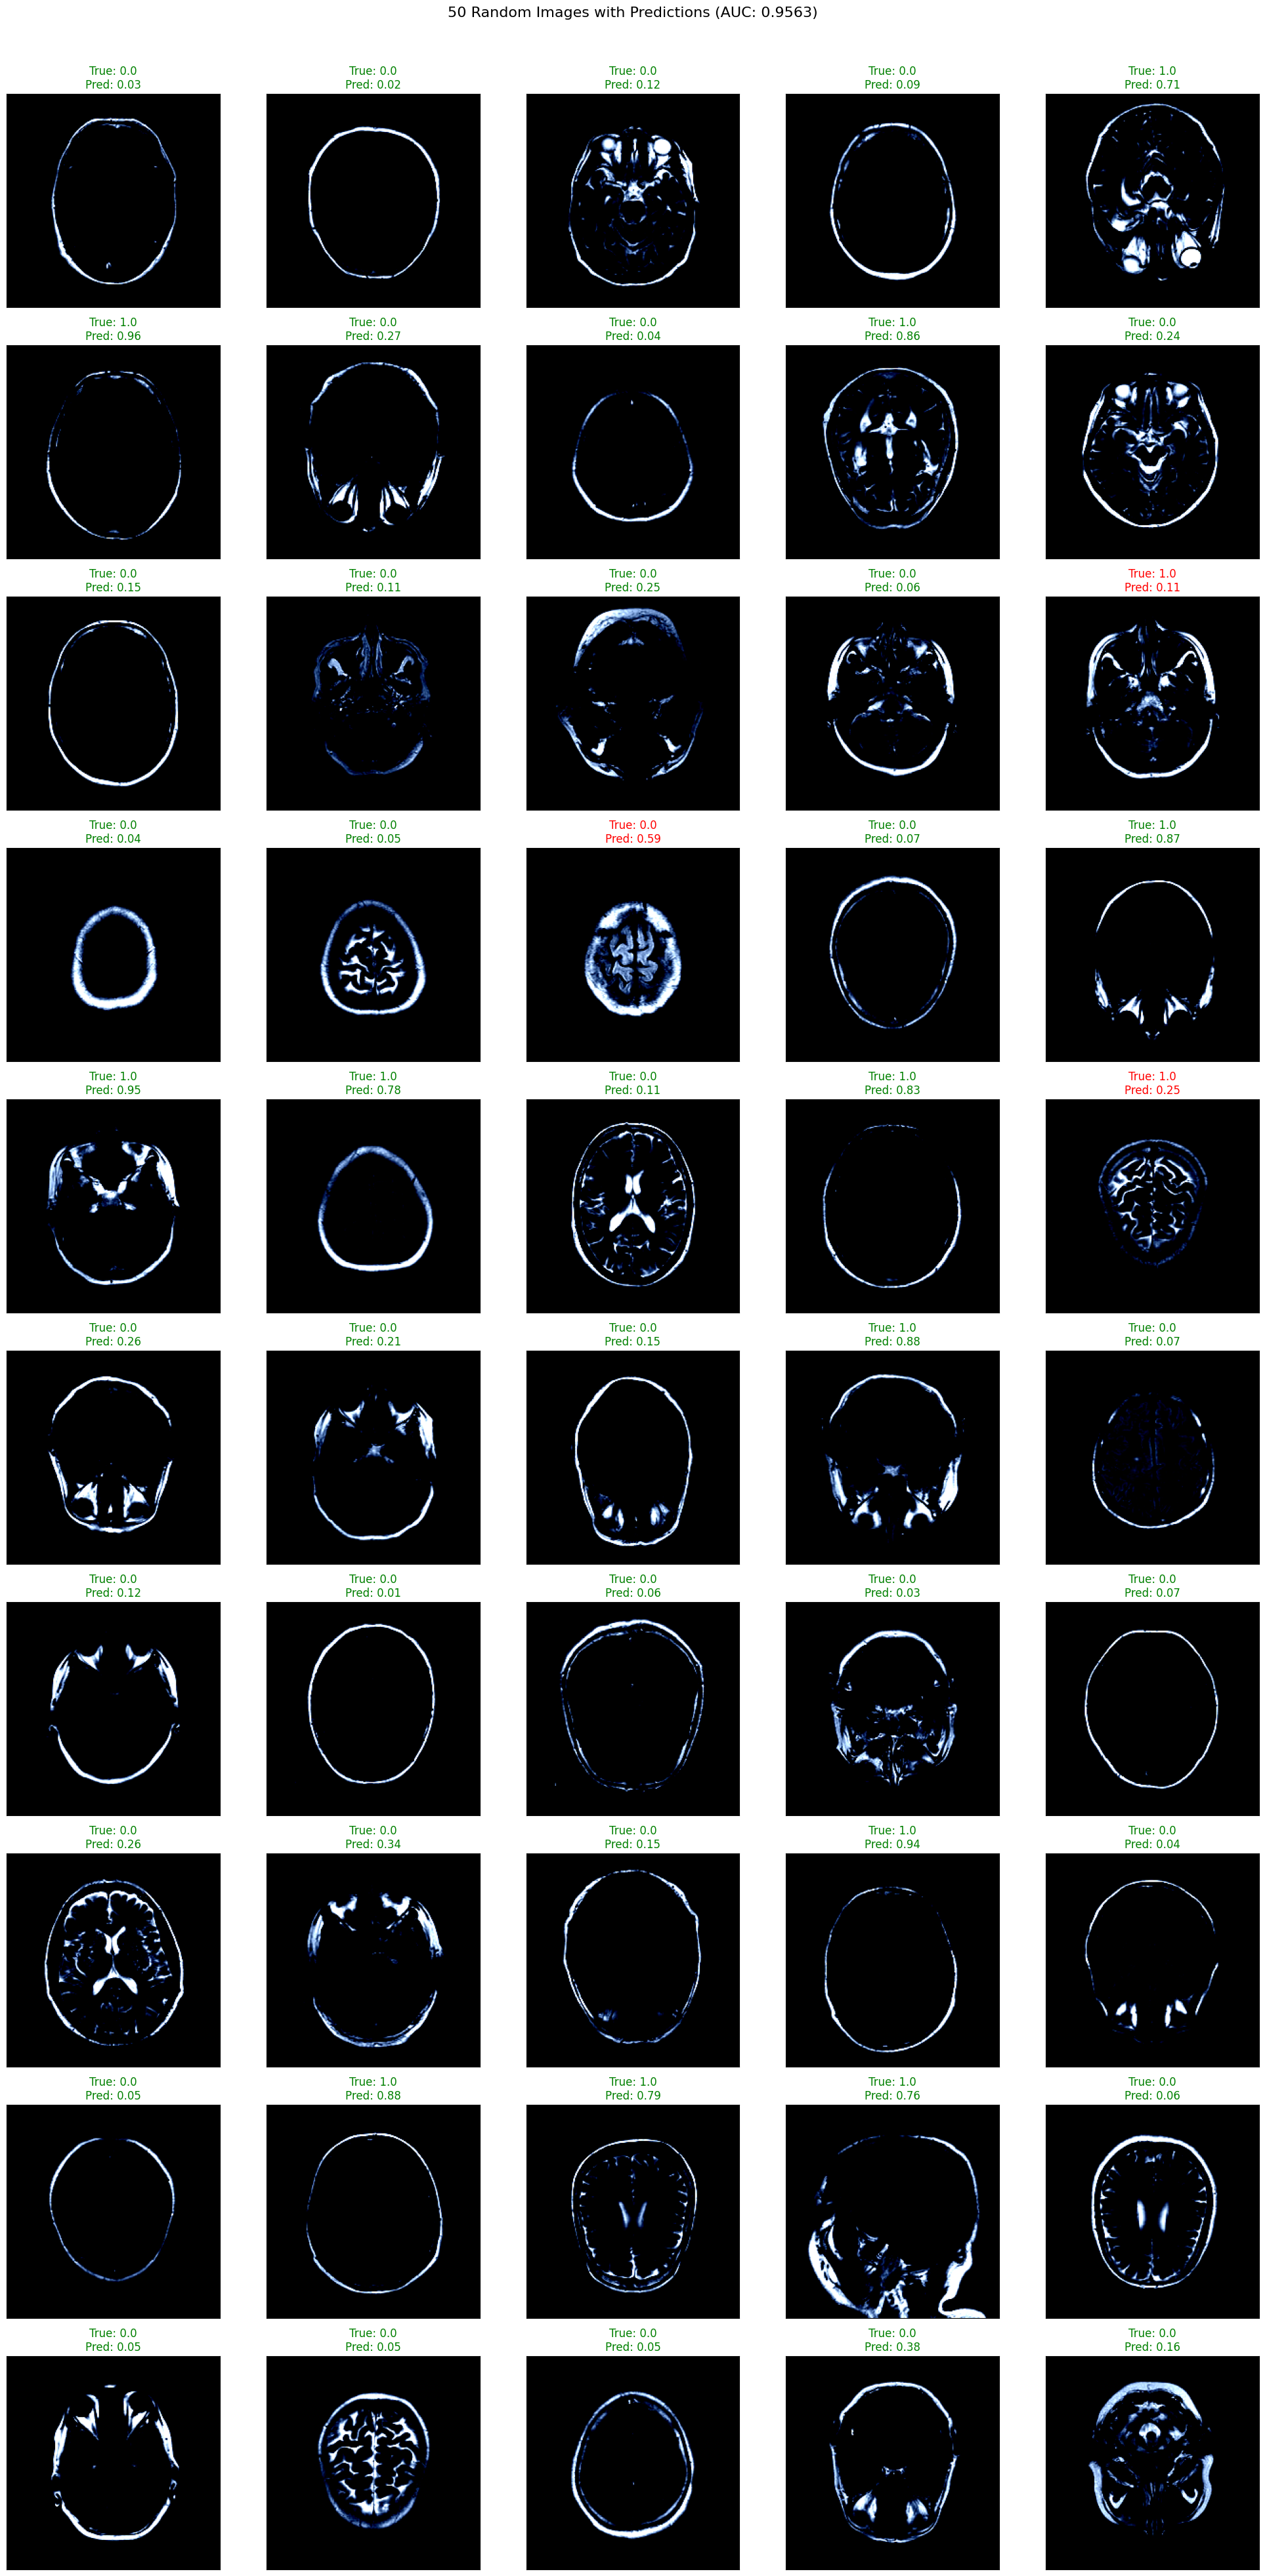

In [7]:
import random
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()

random_indices = random.sample(range(len(test_dataset)), 50)

random_loader = DataLoader([test_dataset[i] for i in random_indices], batch_size=1, shuffle=False)

predictions = []
true_labels = []
images = []

with torch.no_grad():
    for image, label in random_loader:
        image = image.to(device)
        output = model(image)
        pred = torch.sigmoid(output).cpu().numpy()[0][0]
        predictions.append(pred)
        true_labels.append(label.item())
        
        images.append(image.cpu().squeeze().permute(1, 2, 0).numpy())

auc = roc_auc_score(true_labels, predictions)
print(f"AUC for 50 random images: {auc:.4f}")

fig, axes = plt.subplots(10, 5, figsize=(20, 40))
fig.suptitle(f"50 Random Images with Predictions (AUC: {auc:.4f})", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i], cmap='gray')

        ax.set_xticks([])
        ax.set_yticks([])

        pred_class = 1 if predictions[i] > 0.5 else 0
        correct = (pred_class == true_labels[i])
        title_color = 'green' if correct else 'red'

        title = f"True: {true_labels[i]}\nPred: {predictions[i]:.2f}"
        ax.set_title(title, color=title_color)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the suptitle
plt.show()